In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import IPython.display as ipd

#import renamed libraries from the numerical toolbox
from local_signal import *
from general import *


(512, 512)


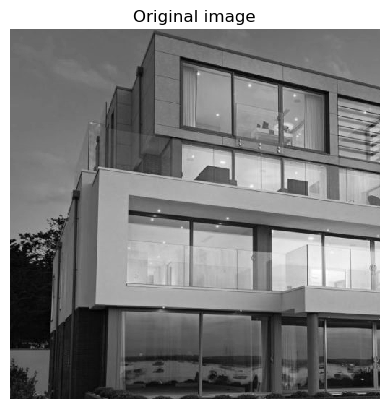

In [2]:
image = load_image('apartment.jpg')
#resize to 512x512
image = image[100:612, 100:612]
image_shape = image.shape
print(image.shape)

imageplot(image, "Original image")

In [3]:
def get_variance(snr, image, noise):
    """
    Function that computes the required variance of the noise to achieve a given SNR.
    """
    #get the norm of the image and the noise
    norm = np.linalg.norm(image)**2
    noise_norm = np.linalg.norm(noise)**2
    #compute the variance
    # variance = norm/(noise_norm*(np.exp((snr/10))))
    variance = norm/(noise_norm*(10**(snr/10)))
    return variance

def generate_noisy_image(snr, image):
    """ 
    Function that generates a noisy image with a given SNR.
    """
    noise = np.random.normal(0, 1, image.shape)
    variance = get_variance(snr, image, noise)
    sigma = np.sqrt(variance)
    noisy_image = image + noise * sigma
    return sigma, noisy_image

def compute_snr(image, noisy_image):
    """
    Function that computes the SNR between an image and a noisy image.
    """
    #get the norm of the image and the noise
    norm = np.linalg.norm(image)**2
    noise_norm = np.linalg.norm(noisy_image - image)**2
    #compute the SNR
    snr = 10*np.log10(norm/noise_norm)
    return snr

0.11029805567399491


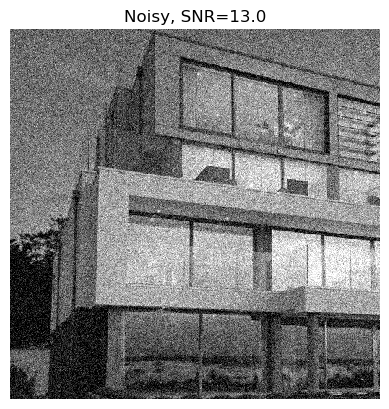

In [4]:
target_SNR = 13
noise_sigma, noisy_image = generate_noisy_image(target_SNR, image)
print(noise_sigma)
imageplot(clamp(noisy_image), "Noisy, SNR=" + str(compute_snr(image, noisy_image)))

Hard thresholding sets the value of the coefficients below a certain threshold to 0.

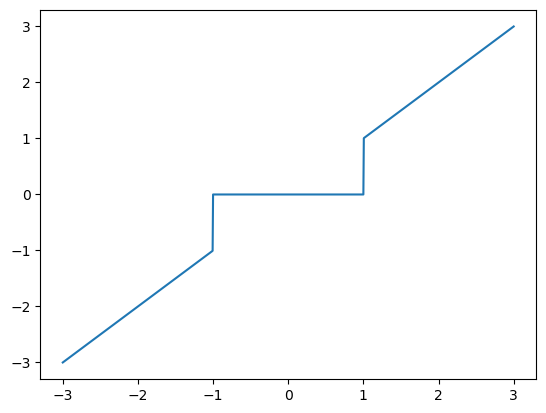

In [5]:
def thresh_hard(u,t):return u*(abs(u)>t)
alpha = np.linspace(-3,3,1000)
plt.plot(alpha, thresh_hard(alpha,1))
plt.show()

In [6]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/np.linalg.norm(h)

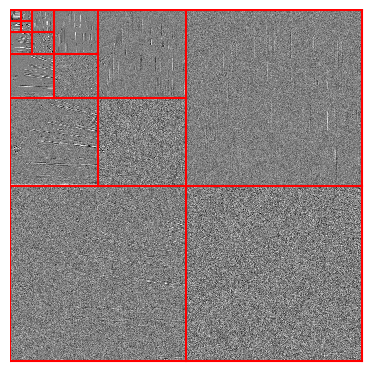

In [7]:
Jmin = 4
a = perform_wavortho_transf(noisy_image,Jmin,+1,h)
plot_wavelet(a,Jmin);

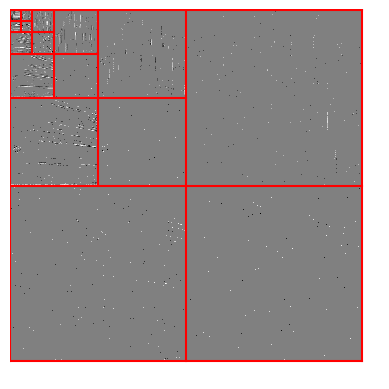

In [8]:
T = 3*noise_sigma
aT = thresh_hard(a,T)
plot_wavelet(aT,Jmin);


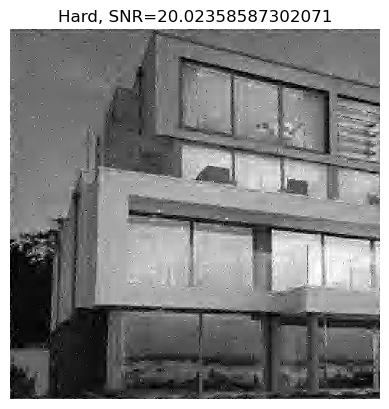

In [9]:
fHard = perform_wavortho_transf(aT,Jmin,-1,h)
imageplot(clamp(fHard), 'Hard, SNR=' + str(snr(image,fHard)) )

Soft thresholding decreases the value of the coefficients below a certain threshold by the threshold value; in other words, it is setting the value of the coefficients below a certain threshold to 0, and then adding the threshold value to the remaining coefficients.

(-3.3, 3.3, -2.2, 2.2)

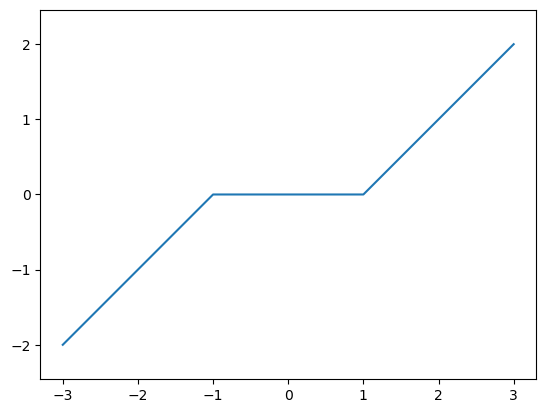

In [10]:
def thresh_soft(u,t):return np.maximum(1-t/abs(u), 0)*u
alpha = np.linspace(-3,3,1000)
plt.plot(alpha, thresh_soft(alpha,1))
plt.axis('equal')

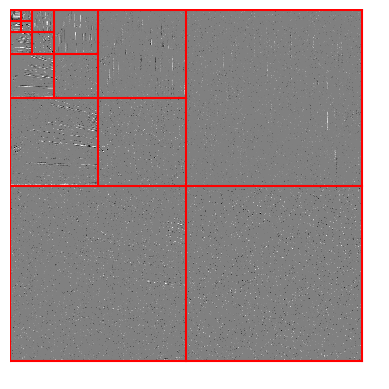

In [11]:
T = 3/2*noise_sigma
aT = thresh_soft(a,T)
plot_wavelet(aT,Jmin);


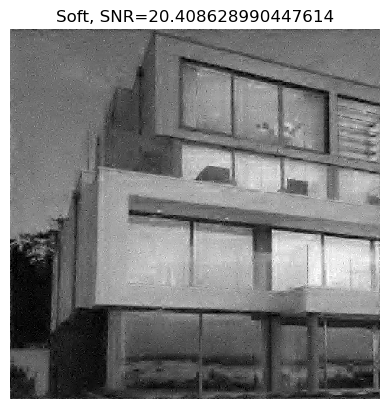

In [12]:
#To slightly improve the soft thresholding performance, we do not threshold the coefficients corresponding to coarse scale wavelets.
aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]

fSoft = perform_wavortho_transf(aT,Jmin,-1,h)
imageplot(clamp(fSoft), 'Soft, SNR=' + str(snr(image,fSoft)) )


The soft thresholding function is less sensitive to noise than the hard thresholding function, but it is also less efficient at removing noise. As a result, it maintains more details than the hard thresholding function at the cost of also preserving some noise.

Translation invariant denoising

In [13]:
m = 8
[dY,dX] = np.meshgrid(np.arange(0,m), np.arange(0,m))
delta = np.concatenate( (dX.reshape(m*m,1), dY.reshape(m*m,1)), axis=1)


In [14]:
fTI = np.zeros(image_shape)
T = 3*noise_sigma
for i in np.arange(0,m*m):
    fS = circshift(noisy_image,delta[i,:])
    a = perform_wavortho_transf(fS,Jmin,1,h)
    aT = thresh_hard(a,T)
    fS = perform_wavortho_transf(aT,Jmin,-1,h)
    fS = circshift(fS,-delta[i,:])
    fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS

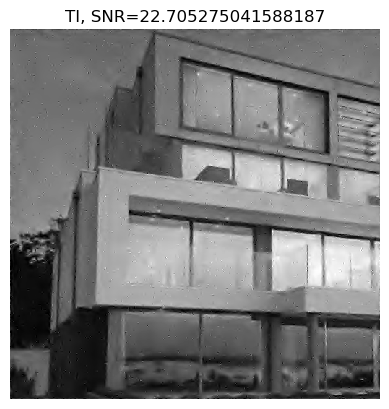

In [15]:
imageplot(clamp(fTI), 'TI, SNR=' + str(snr(image,fTI)) )

Perform a gridsearch on Jmin and thresholding values.

In [16]:
Jmin_values = [1,2,3,4,5,6,7,8]
snr_values = [10,15,20]
thresh=[1,2,3,4,5]
snr_hard = np.zeros((len(Jmin_values),len(snr_values),len(thresh)))
snr_soft = np.zeros((len(Jmin_values),len(snr_values),len(thresh)))

for snr_value in snr_values:
    #create noisy image
    noise_sigma, noisy_image = generate_noisy_image(snr_value, image)
    #apply hard thresholding
    for i in np.arange(0,len(Jmin_values)):
        Jmin = Jmin_values[i]
        a = perform_wavortho_transf(noisy_image,Jmin,+1,h)
        for j in np.arange(0,len(thresh)):
            T = thresh[j]*noise_sigma
            aT = thresh_hard(a,T)
            fHard = perform_wavortho_transf(aT,Jmin,-1,h)
            snr_hard[i,snr_values.index(snr_value),j] = snr(image,fHard)
    #apply soft thresholding
    for i in np.arange(0,len(Jmin_values)):
        Jmin = Jmin_values[i]
        a = perform_wavortho_transf(noisy_image,Jmin,+1,h)
        for j in np.arange(0,len(thresh)):
            T = thresh[j]*noise_sigma
            aT = thresh_soft(a,T)
            fSoft = perform_wavortho_transf(aT,Jmin,-1,h)
            snr_soft[i,snr_values.index(snr_value),j] = snr(image,fSoft)

Note for next cell outputs:

Going up to down on columns => same threshold value, increasing Jmin

Going left to right on rows => same Jmin value, increasing hard/soft thresholds

In [17]:
#snr hard for snr_value 10
snr_hard[:,0,:]

array([[10.84180658, 14.62962348, 18.16252049, 18.23897238, 17.51677225],
       [10.84180658, 14.62962348, 18.16252049, 18.24034736, 17.51793655],
       [10.84180658, 14.63065178, 18.16734719, 18.24526139, 17.52290019],
       [10.84167605, 14.63154517, 18.17610328, 18.26202277, 17.55555802],
       [10.84227816, 14.63767385, 18.2230397 , 18.35393784, 17.68919512],
       [10.83985485, 14.61677394, 18.19342827, 18.43178215, 17.82298473],
       [10.80751025, 14.34226955, 17.36500249, 17.44464325, 16.63278907],
       [10.62895501, 12.90845167, 13.3382637 , 11.11487923,  8.15629384]])

In [18]:
#snr hard for snr_value 15
snr_hard[:,1,:]

array([[15.76796177, 18.99291604, 21.27892489, 20.74226301, 19.85533256],
       [15.76796177, 18.99291604, 21.27892489, 20.74226301, 19.85533256],
       [15.76796177, 18.99291604, 21.2801173 , 20.74331679, 19.85619167],
       [15.76811079, 18.99381857, 21.28469273, 20.75192665, 19.8731431 ],
       [15.76833673, 19.00069342, 21.31533331, 20.81875445, 19.96642684],
       [15.76857518, 19.00690247, 21.38738578, 20.96365088, 20.17079236],
       [15.74492769, 18.82748888, 20.96029086, 20.59107454, 19.82312885],
       [15.59496444, 17.70982273, 18.65523921, 18.01560328, 16.75939029]])

In [19]:
#snr hard for snr_value 20
snr_hard[:,2,:]

array([[20.69000401, 23.3309506 , 24.49258622, 23.61933907, 22.623033  ],
       [20.69000401, 23.3309506 , 24.49258622, 23.61933907, 22.623033  ],
       [20.69000401, 23.3309506 , 24.49258622, 23.61933907, 22.623033  ],
       [20.69003462, 23.331313  , 24.49298813, 23.62069307, 22.62676272],
       [20.69050108, 23.33804371, 24.51801599, 23.65894455, 22.68604606],
       [20.69084448, 23.34887051, 24.58165933, 23.79034464, 22.86946318],
       [20.67645222, 23.26748451, 24.51022713, 23.79889467, 22.92467702],
       [20.55185668, 22.42814845, 23.04151336, 22.35826616, 21.47657241]])

In [20]:
#snr soft thresholding for snr_value 10
snr_soft[:,0,:]

array([[16.69710552, 18.63544666, 17.41053378, 16.37383045, 15.61509053],
       [16.69587304, 18.63159618, 17.40617777, 16.36906852, 15.60960221],
       [16.69345068, 18.62352156, 17.39515687, 16.35528551, 15.59317878],
       [16.68558092, 18.59470302, 17.35206204, 16.29593934, 15.51266274],
       [16.64062571, 18.38798941, 17.01130923, 15.81116388, 14.86714153],
       [16.35934025, 17.2937093 , 15.43864774, 13.82229695, 12.47758567],
       [15.22424947, 14.24033917, 11.72384161,  9.68586294,  8.03042389],
       [12.24126963,  9.34628868,  6.57633974,  4.5194729 ,  3.0124852 ]])

In [21]:
#snr soft thresholding for snr_value 15
snr_soft[:,1,:]

array([[20.84478125, 21.2239451 , 19.6409485 , 18.45208578, 17.58355781],
       [20.84477199, 21.22392489, 19.64092744, 18.45206442, 17.58353595],
       [20.84432157, 21.22294192, 19.63980371, 18.4505708 , 17.58172978],
       [20.84484487, 21.22128738, 19.6347305 , 18.44057262, 17.56503455],
       [20.82365299, 21.14364628, 19.50743756, 18.25340814, 17.30530458],
       [20.64932074, 20.59618083, 18.70077957, 17.18456126, 15.96865669],
       [19.72198348, 18.39664592, 15.96335115, 14.02619779, 12.45516925],
       [16.99669023, 14.01266199, 11.20746852,  9.04561624,  7.3217806 ]])

In [22]:
#snr soft thresholding for snr_value 20
snr_soft[:,2,:]

array([[24.82059587, 24.04162488, 22.19426669, 20.85908163, 19.87293536],
       [24.82108702, 24.04244592, 22.19507155, 20.85987074, 19.87372138],
       [24.82012172, 24.04083232, 22.19348975, 20.85831988, 19.8721766 ],
       [24.81853059, 24.03781273, 22.18960993, 20.85325038, 19.86541488],
       [24.80628896, 24.00442289, 22.13665268, 20.77610652, 19.75936423],
       [24.69107759, 23.71788059, 21.728389  , 20.23202337, 19.06784592],
       [24.00991436, 22.28299265, 19.90216263, 18.05380022, 16.56660783],
       [21.63274277, 18.58106041, 15.79737433, 13.6583564 , 11.94545099]])

The wavelet transform uses 2 paremeters: an orthogonal wavelet, and the number of levels/coefficients to compute.

In the wavelet domain, it is possible to apply a thresholding function (hard or soft) to the coefficients, and then to reconstruct the image using the inverse wavelet transform.

The wavelet used is the Daubechies-4 wavelet.

The number of coefficients to compute is based on Jmin; for an image of size $2^n$, the number of coefficients computed is $2^{n-Jmin}$.

The higher level-coefficients will compute low frequency features.

According to the gridsearch done on these two parameters; it seems that after the first 4 coefficients are computed, thresholding level becomes more important. For a small amount of coefficients (e.g. 1), the wavelet domain is much more sensitive to noise and a higher threshold causes a lot of information to be lost, compared to the high amount of coefficients.